## Contrastive Language-Image Pretraining (CLIP) Model

### Setup

In [2]:
# import dependencies
import os
import random
from pathlib import Path
from typing import Dict, List
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, AutoConfig, get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\Isabella\Desktop\dsa4213\project\DSA4213-Group26\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# CONFIGURATIONS
TRAIN_TSV = '../data/fakeddit_train.tsv'
VAL_TSV = '../data/fakeddit_val.tsv'
TEST_TSV = '../data/fakeddit_test.tsv'
IMG_DIR = '../data/images/'

MODEL_NAME = 'openai/clip-vit-base-patch32'
OUTPUT_DIR = '../models/clip/'

BATCH_SIZE = 16
WEIGHT_DECAY = 1e-2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_LABELS = 3
SEED = 42

# set seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
# load datasets
train_df = pd.read_csv(TRAIN_TSV, sep='\t')
val_df = pd.read_csv(VAL_TSV, sep='\t')
test_df = pd.read_csv(TEST_TSV, sep='\t')

In [5]:
# class weighting due to class imbalance
y_train = train_df['3_way_label']

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(DEVICE)

print("Class weights:", class_weights)

# to use this as loss later
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Class weights: tensor([0.6042, 9.2801, 0.8083])


### Create Dataset

In [6]:
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

class FakedditDataset(Dataset):
    def __init__(self, df, img_dir, processor, id_col='id', text_col='clean_title', label_col='3_way_label'):
        self.df = df
        self.img_dir = img_dir
        self.processor = processor
        self.id_col = id_col
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row[self.text_col])
        label = int(row[self.label_col])

        # Load image
        img_path = os.path.join(self.img_dir, f"{row[self.id_col]}.jpg")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = Image.open(img_path).convert("RGB")

        return {"text": text, "image": image, "labels": torch.tensor(label)}

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
# collate function to handle padding and batching
def collate_fn(batch):
    texts = [item["text"] for item in batch]
    images = [item["image"] for item in batch]
    labels = torch.tensor([item["labels"] for item in batch])

    inputs = processor(
        text=texts,
        images=images,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )
    inputs["labels"] = labels
    return inputs

In [8]:
# create datasets
train_ds = FakedditDataset(train_df, IMG_DIR, processor)
val_ds = FakedditDataset(val_df, IMG_DIR, processor)
test_ds = FakedditDataset(test_df, IMG_DIR, processor)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### Create CLIP Classification Model

In [75]:
class CLIPClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=NUM_LABELS, dropout=0.2):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(model_name)
        embed_dim = self.clip.config.projection_dim
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(embed_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        text_feats = self.clip.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        img_feats = self.clip.get_image_features(pixel_values=pixel_values)
        text_feats = nn.functional.normalize(text_feats, dim=-1)
        img_feats = nn.functional.normalize(img_feats, dim=-1)
        fused = torch.cat([text_feats, img_feats], dim=-1)
        x = self.dropout(fused)
        logits = self.classifier(x)
        return logits

### Evaluation Helper

In [14]:
def evaluate_model(model, data_loader):
    model.eval()
    preds, labels = [], []
    total_loss = 0.0

    loop = tqdm(data_loader, desc="Evaluating")

    with torch.no_grad():
        for batch in loop:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask'], 
                pixel_values=batch['pixel_values']
            )
            loss = criterion(logits, batch['labels'])
            total_loss += loss.item()

            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(batch['labels'].cpu().tolist())

            loop.set_postfix(loss=loss.item())

    # get metric scores
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)

    return {'loss': avg_loss, 'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}


### Fine-Tuning Classifier Head (dropout=0.2)

In [ ]:
# training setup
EPOCHS = 5
LEARNING_RATE = 1e-4
DROPOUT = 0.2

model = CLIPClassifier(MODEL_NAME, NUM_LABELS, DROPOUT).to(DEVICE)
for param in model.clip.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.05 * total_steps), 
    num_training_steps=total_steps
)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 3075


#### Training Loop

In [ ]:
best_f1_2 = 0.0
train_losses_2 = []
train_accuracies_2 = []
train_f1s_2 = []
val_losses_2 = []
val_accuracies_2 = []
val_f1s_2 = []

# training loop
for epoch in range(EPOCHS):

    # train on train set
    model.train()
    total_loss = 0.0
    all_train_preds, all_train_labels = [], []
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optimizer.zero_grad()
        logits = model(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask'], 
            pixel_values=batch['pixel_values']
        )
        loss = criterion(logits, batch['labels'])
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(batch["labels"].cpu().numpy())

        loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average="macro")

    train_losses_2.append(avg_loss)
    train_accuracies_2.append(train_acc)
    train_f1s_2.append(train_f1)
    print(f"Train: Loss={avg_loss:.4f}, Accuracy={train_acc:.4f}, F1={train_f1:.4f}")

    # evaluate on validation set
    val_metrics = evaluate_model(model, val_loader)
    
    val_losses_2.append(val_metrics['loss'])
    val_accuracies_2.append(val_metrics['accuracy'])
    val_f1s_2.append(val_metrics['f1'])
    print(f"Validation: Loss={val_metrics['loss']:.4f}, Accuracy={val_metrics['accuracy']:.4f}, F1={val_metrics['f1']:.4f}")

    # save best model
    if val_metrics['f1'] > best_f1_2:
        best_f1_2 = val_metrics['f1']
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model_classifier_2.pt'))
        print("Best model saved.")

print(f"Best Validation F1: {best_f1_2:.4f}")

Epoch 1/5: 100%|██████████| 1887/1887 [1:32:38<00:00,  2.95s/it, loss=0.831]


Train: Loss=0.9645, Accuracy=0.7649, F1=0.7803


Evaluating: 100%|██████████| 236/236 [11:17<00:00,  2.87s/it, loss=0.881]


Validation: Loss=0.8951, Accuracy=0.7839, F1=0.7952
Best model saved.


Epoch 2/5: 100%|██████████| 1887/1887 [1:24:40<00:00,  2.69s/it, loss=0.758]


Train: Loss=0.8386, Accuracy=0.7908, F1=0.8100


Evaluating: 100%|██████████| 236/236 [10:21<00:00,  2.63s/it, loss=0.806]


Validation: Loss=0.8052, Accuracy=0.7861, F1=0.7958
Best model saved.


Epoch 3/5: 100%|██████████| 1887/1887 [1:22:29<00:00,  2.62s/it, loss=0.781]


Train: Loss=0.7689, Accuracy=0.7907, F1=0.8058


Evaluating: 100%|██████████| 236/236 [10:19<00:00,  2.62s/it, loss=0.768]


Validation: Loss=0.7545, Accuracy=0.7882, F1=0.7939


Epoch 4/5: 100%|██████████| 1887/1887 [1:22:44<00:00,  2.63s/it, loss=0.849]


Train: Loss=0.7309, Accuracy=0.7933, F1=0.8092


Evaluating: 100%|██████████| 236/236 [10:18<00:00,  2.62s/it, loss=0.749]


Validation: Loss=0.7298, Accuracy=0.7879, F1=0.7932


Epoch 5/5: 100%|██████████| 1887/1887 [1:22:34<00:00,  2.63s/it, loss=0.621]


Train: Loss=0.7150, Accuracy=0.7930, F1=0.8077


Evaluating: 100%|██████████| 236/236 [10:23<00:00,  2.64s/it, loss=0.745]

Validation: Loss=0.7246, Accuracy=0.7882, F1=0.7935
Best Validation F1: 0.7958


In [35]:
print("=== Fine-tuning Classifier Head (dropout=0.2) Metrics ===")
print(f"Train Losses: {train_losses_2}")
print(f"Train Accuracies: {train_accuracies_2}")
print(f"Train F1 Scores: {train_f1s_2}")
print(f"Validation Losses: {val_losses_2}")
print(f"Validation Accuracies: {val_accuracies_2}")
print(f"Validation F1 Scores: {val_f1s_2}")

=== Fine-tuning Classifier Head (dropout=0.2) Metrics ===
Train Losses: [0.9644907061928596, 0.8385673417385507, 0.7688664252093436, 0.7308966441323786, 0.715010223861845]
Train Accuracies: [0.7648696113191292, 0.7908479406209616, 0.7906822625004142, 0.7933331124291726, 0.7930348918121873]
Train F1 Scores: [0.7803179397448282, 0.8099920063288032, 0.8057626955917246, 0.8091939391675679, 0.807680382794396]
Validation Losses: [0.8950714746774253, 0.8051989285622613, 0.7545444375630153, 0.7297540266635054, 0.7245809079731925]
Validation Accuracies: [0.7839342523860021, 0.7860551431601273, 0.7881760339342524, 0.7879109225874867, 0.7881760339342524]
Validation F1 Scores: [0.7951889254628339, 0.7958155369284174, 0.7938929415585517, 0.793248135233707, 0.7934524696804951]


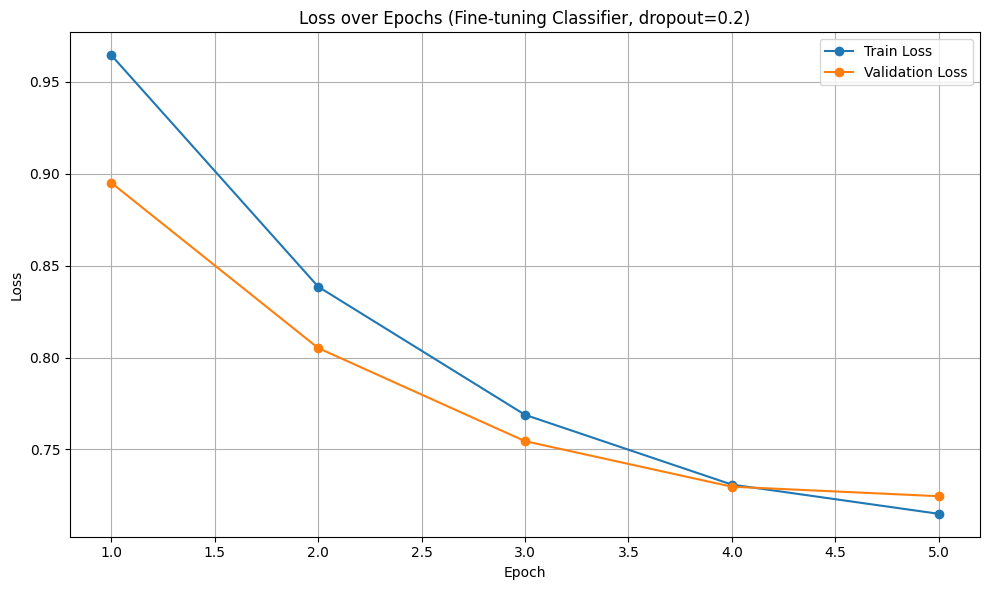

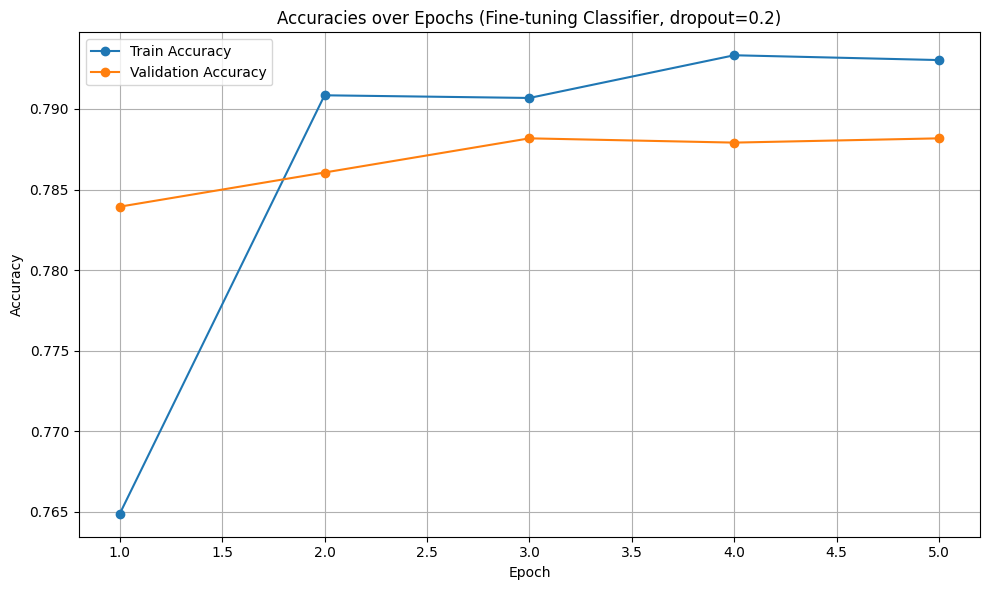

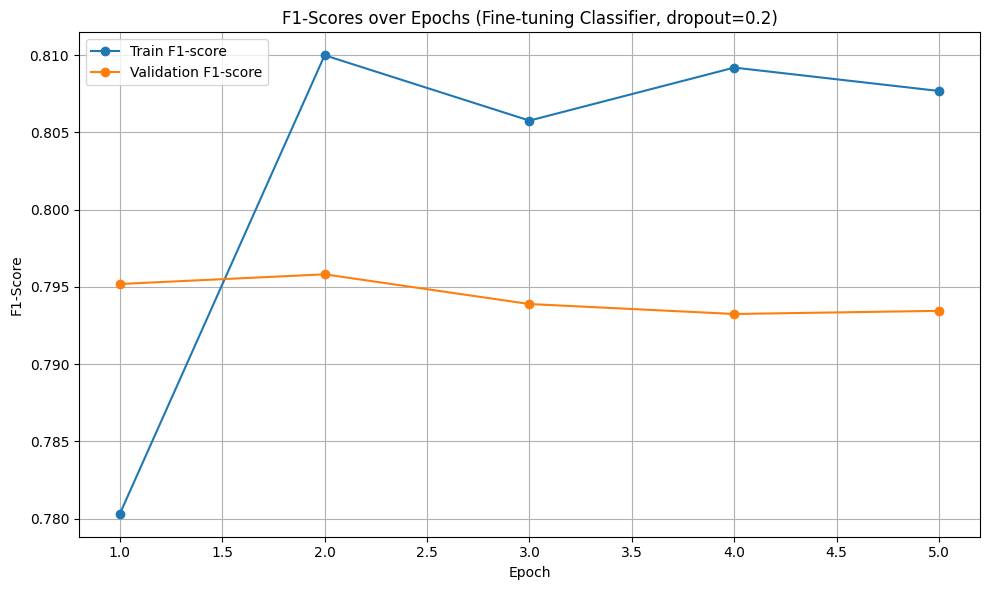

In [36]:
# plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_losses_2, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses_2, marker='o', label='Validation Loss')
plt.title('Loss over Epochs (Fine-tuning Classifier, dropout=0.2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_accuracies_2, marker='o', label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies_2, marker='o', label='Validation Accuracy')
plt.title('Accuracies over Epochs (Fine-tuning Classifier, dropout=0.2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot f1 curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_f1s_2, marker='o', label='Train F1-score')
plt.plot(range(1, EPOCHS+1), val_f1s_2, marker='o', label='Validation F1-score')
plt.title('F1-Scores over Epochs (Fine-tuning Classifier, dropout=0.2)')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluation on Test Set

In [ ]:
# compute evaluation metrics
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_classifier_2.pt'), map_location=DEVICE))
test_metrics = evaluate_model(model, test_loader)
print("Test Metrics (Fine-tuning Classifier):", test_metrics)

Evaluating: 100%|██████████| 236/236 [11:09<00:00,  2.84s/it, loss=0.651]

Test Metrics (Fine-tuning Classifier): {'loss': 0.7984069893925877, 'accuracy': 0.7935329976146303, 'f1': 0.8116536336498953, 'precision': 0.8116522463771658, 'recall': 0.8136559949067204}


In [ ]:
# load best model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_classifier_2.pt'), map_location=DEVICE))
model.eval()

# define label names
label_names = ['True', 'Misleading', 'Fake']

# collect predictions, labels, and probabilities
all_preds, all_labels, all_probs = [], [], []

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# convert to numpy array
all_probs = np.array(all_probs)

Testing: 100%|██████████| 236/236 [11:01<00:00,  2.80s/it]


In [37]:
# print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (Fine-tuning Classifier, dropout=0.2) ===\n')
print(report)


=== Classification Report (Fine-tuning Classifier, dropout=0.2) ===

              precision    recall  f1-score   support

        True     0.7970    0.8525    0.8239      2082
  Misleading     0.8561    0.8815    0.8686       135
        Fake     0.7818    0.7069    0.7425      1556

    accuracy                         0.7935      3773
   macro avg     0.8117    0.8137    0.8117      3773
weighted avg     0.7929    0.7935    0.7919      3773



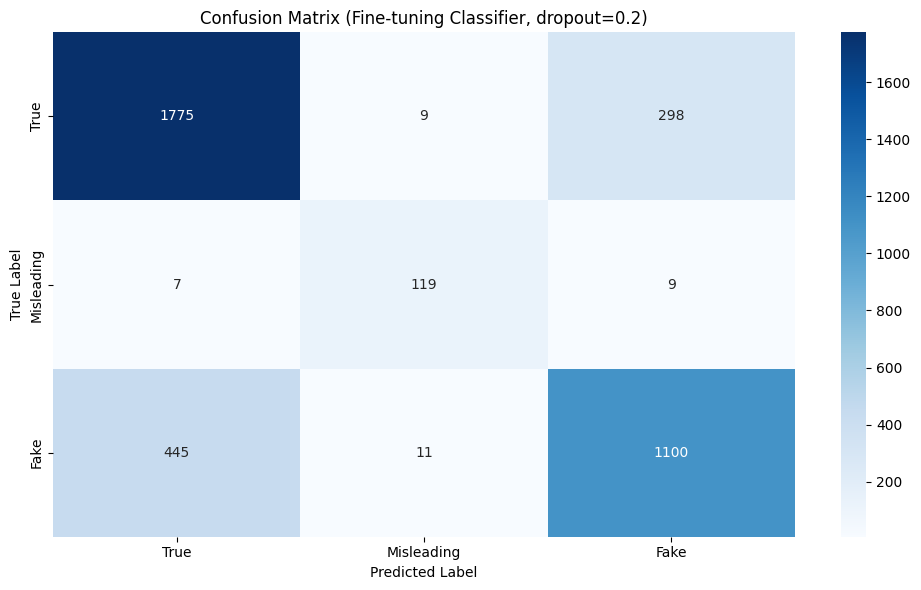

In [38]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Fine-tuning Classifier, dropout=0.2)')
plt.tight_layout()
plt.show()

In [22]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

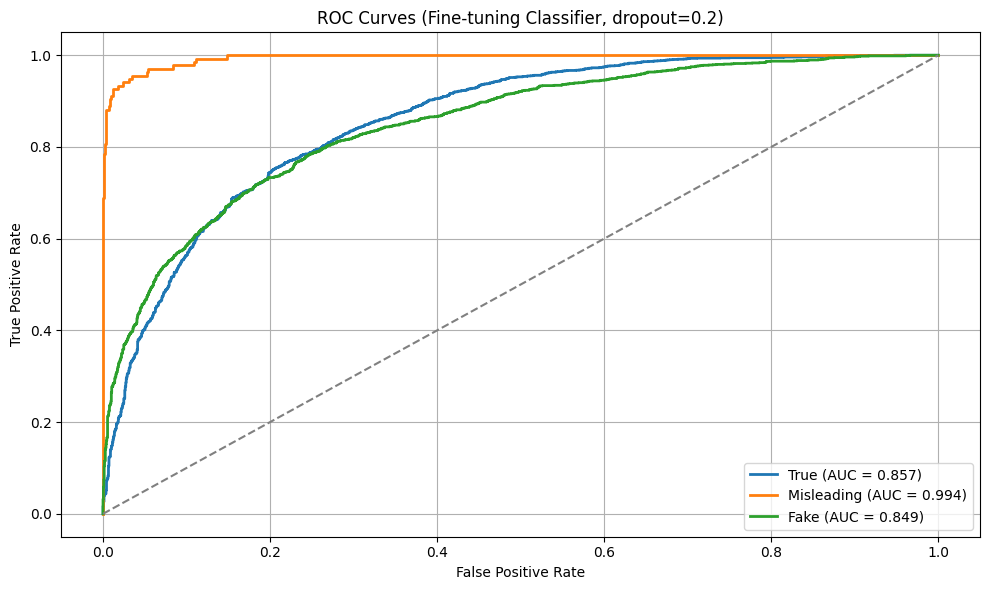

In [39]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Fine-tuning Classifier, dropout=0.2)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

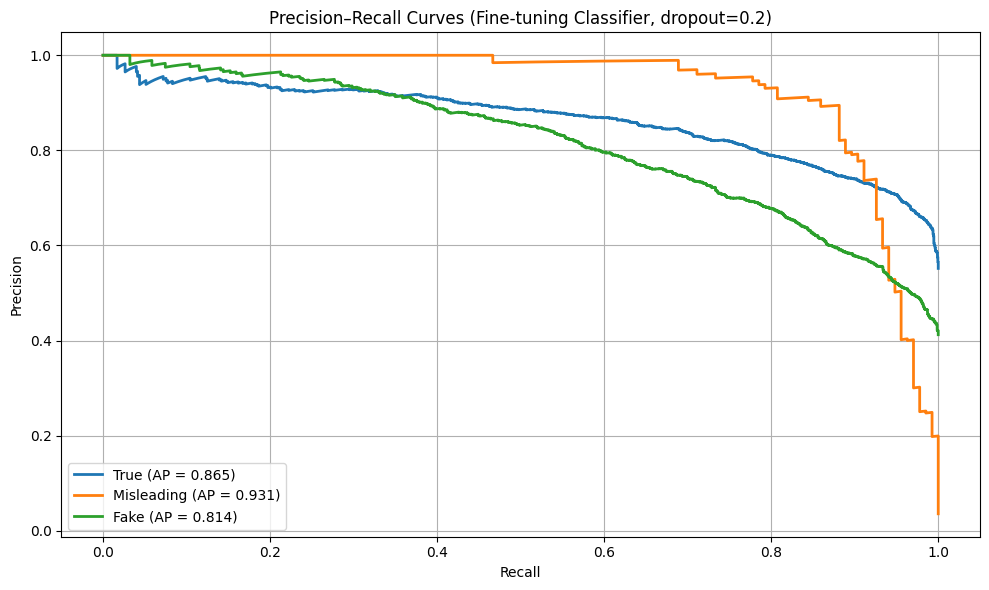

In [40]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Fine-tuning Classifier, dropout=0.2)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Total misclassified samples: 779 / 3773


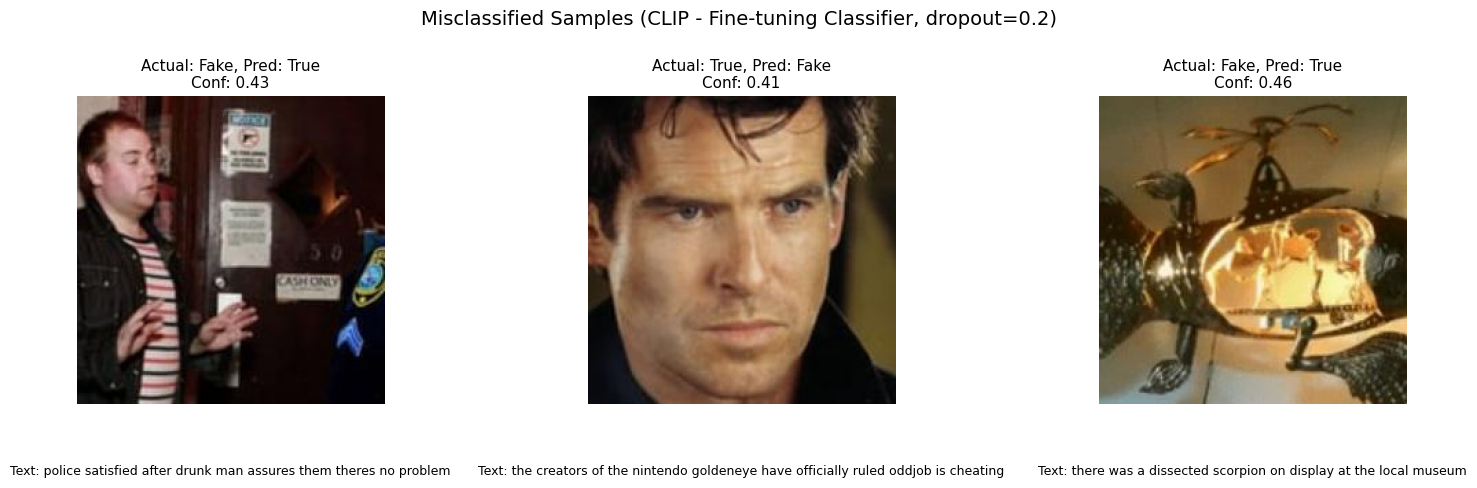

In [44]:
# collect misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]
print(f"Total misclassified samples: {len(misclassified_indices)} / {len(all_labels)}")

# randomly sample a few error cases
num_samples = min(3, len(misclassified_indices))
sampled_errors = random.sample(misclassified_indices, num_samples)

# plot misclassified samples
plt.figure(figsize=(15, 8))

for idx, sample_idx in enumerate(sampled_errors, 1):
    row = test_df.iloc[sample_idx]
    image_id = row["id"]
    image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")

    if not os.path.exists(image_path):
        continue  
    
    image = Image.open(image_path).convert("RGB")

    true_label = label_names[all_labels[sample_idx]]
    pred_label = label_names[all_preds[sample_idx]]
    probs = all_probs[sample_idx]
    confidence = np.max(probs)

    text = str(row.get("clean_title", ""))
    if len(text) > 120:
        text = text[:117] + "..."

    plt.subplot(2, 3, idx)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Actual: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}",
        fontsize=11,
        color="black"
    )
    plt.text(
        0.5, -0.2, 
        f"Text: {text}",
        fontsize=9,
        ha="center",
        va="top",
        wrap=True,
        transform=plt.gca().transAxes
    )

plt.suptitle("Misclassified Samples (CLIP - Fine-tuning Classifier, dropout=0.2)", fontsize=14, y=1)
plt.tight_layout()
plt.show()

### Fine-Tuning Classifier Head (dropout=0.3)

In [ ]:
# training setup
EPOCHS = 5
LEARNING_RATE = 1e-4
DROPOUT = 0.3

model = CLIPClassifier(MODEL_NAME, NUM_LABELS, DROPOUT).to(DEVICE)
for param in model.clip.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.05 * total_steps), 
    num_training_steps=total_steps
)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 3075


#### Training Loop

In [78]:
best_f1_3 = 0.0
train_losses_3 = []
train_accuracies_3 = []
train_f1s_3 = []
val_losses_3 = []
val_accuracies_3 = []
val_f1s_3 = []

# training loop
for epoch in range(EPOCHS):

    # train on train set
    model.train()
    total_loss = 0.0
    all_train_preds, all_train_labels = [], []
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optimizer.zero_grad()
        logits = model(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask'], 
            pixel_values=batch['pixel_values']
        )
        loss = criterion(logits, batch['labels'])
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(batch["labels"].cpu().numpy())

        loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average="macro")

    train_losses_3.append(avg_loss)
    train_accuracies_3.append(train_acc)
    train_f1s_3.append(train_f1)
    print(f"Train: Loss={avg_loss:.4f}, Accuracy={train_acc:.4f}, F1={train_f1:.4f}")

    # evaluate on validation set
    val_metrics = evaluate_model(model, val_loader)
    
    val_losses_3.append(val_metrics['loss'])
    val_accuracies_3.append(val_metrics['accuracy'])
    val_f1s_3.append(val_metrics['f1'])
    print(f"Validation: Loss={val_metrics['loss']:.4f}, Accuracy={val_metrics['accuracy']:.4f}, F1={val_metrics['f1']:.4f}")

    # save best model
    if val_metrics['f1'] > best_f1_3:
        best_f1_3 = val_metrics['f1']
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model_classifier_3.pt'))
        print("Best model saved.")

print(f"Best Validation F1: {best_f1_3:.4f}")

Epoch 1/5: 100%|██████████| 1887/1887 [1:26:34<00:00,  2.75s/it, loss=0.892]


Train: Loss=1.0178, Accuracy=0.6754, F1=0.5899


Evaluating: 100%|██████████| 236/236 [10:43<00:00,  2.73s/it, loss=0.915]


Validation: Loss=0.9370, Accuracy=0.7818, F1=0.7889
Best model saved.


Epoch 2/5: 100%|██████████| 1887/1887 [1:26:20<00:00,  2.75s/it, loss=0.788]


Train: Loss=0.8748, Accuracy=0.7828, F1=0.7985


Evaluating: 100%|██████████| 236/236 [11:32<00:00,  2.93s/it, loss=0.826]


Validation: Loss=0.8356, Accuracy=0.7866, F1=0.7980
Best model saved.


Epoch 3/5: 100%|██████████| 1887/1887 [1:28:25<00:00,  2.81s/it, loss=0.616]


Train: Loss=0.7969, Accuracy=0.7864, F1=0.8009


Evaluating: 100%|██████████| 236/236 [10:31<00:00,  2.68s/it, loss=0.782]


Validation: Loss=0.7779, Accuracy=0.7890, F1=0.7962


Epoch 4/5: 100%|██████████| 1887/1887 [1:26:58<00:00,  2.77s/it, loss=0.78] 


Train: Loss=0.7522, Accuracy=0.7874, F1=0.8008


Evaluating: 100%|██████████| 236/236 [10:58<00:00,  2.79s/it, loss=0.76] 


Validation: Loss=0.7474, Accuracy=0.7866, F1=0.7946


Epoch 5/5: 100%|██████████| 1887/1887 [1:24:41<00:00,  2.69s/it, loss=0.86] 


Train: Loss=0.7333, Accuracy=0.7866, F1=0.8001


Evaluating: 100%|██████████| 236/236 [10:33<00:00,  2.68s/it, loss=0.754]

Validation: Loss=0.7378, Accuracy=0.7861, F1=0.7936
Best Validation F1: 0.7980


In [79]:
print("=== Fine-tuning Classifier Head (dropout=0.3) Metrics ===")
print(f"Train Losses: {train_losses_3}")
print(f"Train Accuracies: {train_accuracies_3}")
print(f"Train F1 Scores: {train_f1s_3}")
print(f"Validation Losses: {val_losses_3}")
print(f"Validation Accuracies: {val_accuracies_3}")
print(f"Validation F1 Scores: {val_f1s_3}")

=== Fine-tuning Classifier Head (dropout=0.3) Metrics ===
Train Losses: [1.017750018351787, 0.8748194650170913, 0.7968796677354409, 0.7522242946257083, 0.73325028712306]
Train Accuracies: [0.6754034262235329, 0.7828291195864674, 0.7864077669902912, 0.7874018357135757, 0.7866397163590576]
Train F1 Scores: [0.5899382731790433, 0.798482589447037, 0.8008800186416906, 0.8008122749933739, 0.8001044780172099]
Validation Losses: [0.9370103978504569, 0.8355946490320109, 0.77789832878921, 0.7474206511752081, 0.737793752828897]
Validation Accuracies: [0.781813361611877, 0.7865853658536586, 0.7889713679745494, 0.7865853658536586, 0.7860551431601273]
Validation F1 Scores: [0.788915322230939, 0.7979870673347617, 0.7962338437080626, 0.7945791260749177, 0.7935828793819969]


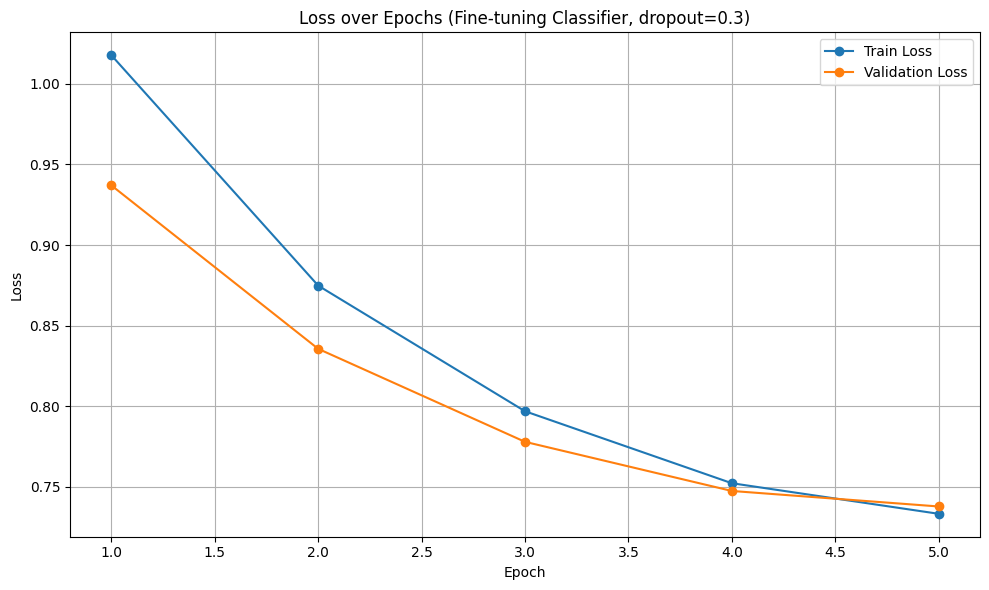

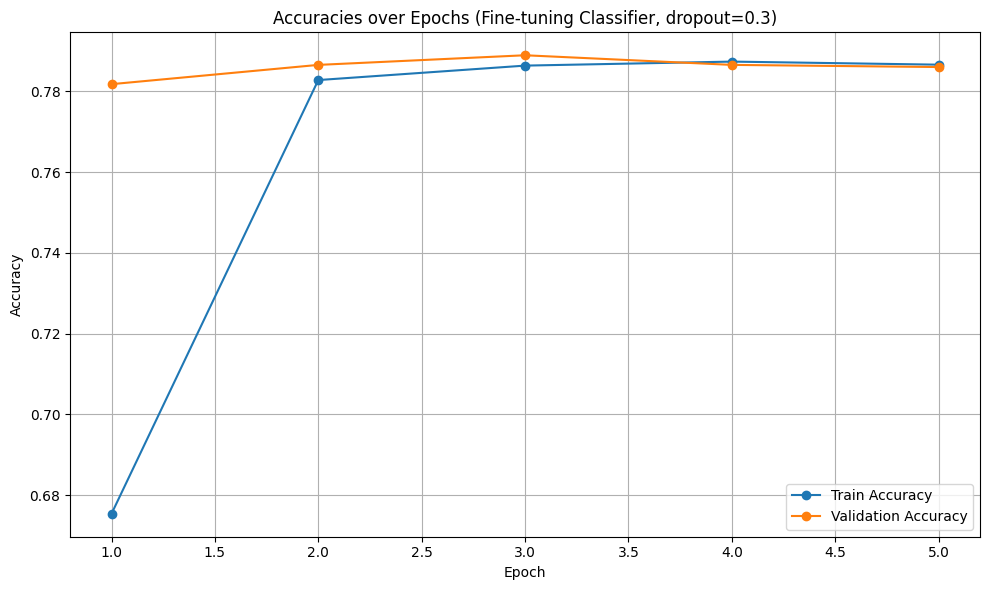

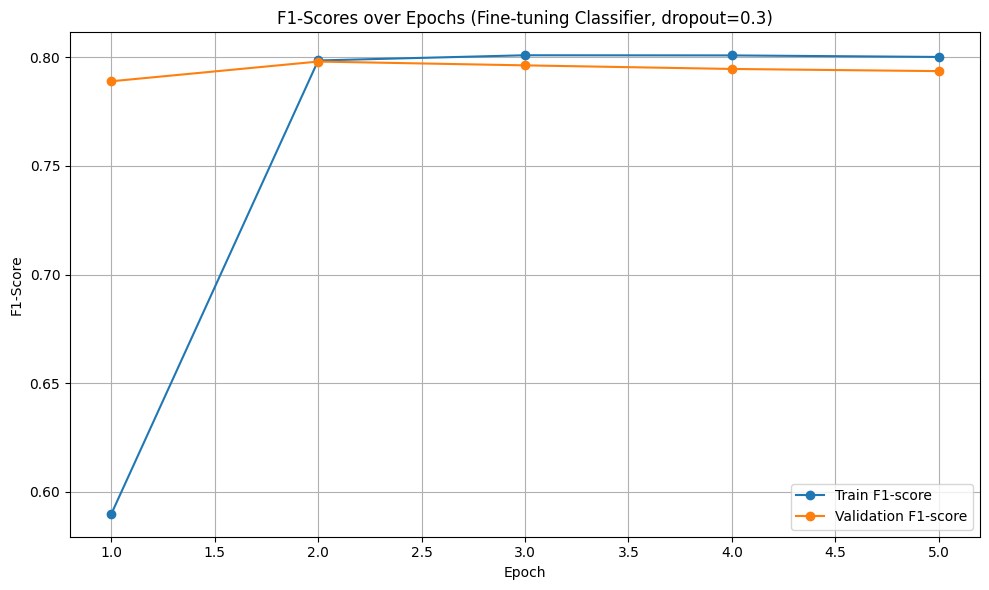

In [80]:
# plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_losses_3, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses_3, marker='o', label='Validation Loss')
plt.title('Loss over Epochs (Fine-tuning Classifier, dropout=0.3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_accuracies_3, marker='o', label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies_3, marker='o', label='Validation Accuracy')
plt.title('Accuracies over Epochs (Fine-tuning Classifier, dropout=0.3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot f1 curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_f1s_3, marker='o', label='Train F1-score')
plt.plot(range(1, EPOCHS+1), val_f1s_3, marker='o', label='Validation F1-score')
plt.title('F1-Scores over Epochs (Fine-tuning Classifier, dropout=0.3)')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluation on Test Set

In [81]:
# compute evaluation metrics
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_classifier_3.pt'), map_location=DEVICE))
test_metrics = evaluate_model(model, test_loader)
print("Test Metrics (Fine-tuning Classifier):", test_metrics)

Evaluating: 100%|██████████| 236/236 [12:49<00:00,  3.26s/it, loss=0.707]

Test Metrics (Fine-tuning Classifier): {'loss': 0.8290627603813753, 'accuracy': 0.7927378743705275, 'f1': 0.8096812072038456, 'precision': 0.8155912463058911, 'recall': 0.8071504477518568}


In [82]:
# load best model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_classifier_3.pt'), map_location=DEVICE))
model.eval()

# define label names
label_names = ['True', 'Misleading', 'Fake']

# collect predictions, labels, and probabilities
all_preds, all_labels, all_probs = [], [], []

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# convert to numpy array
all_probs = np.array(all_probs)

Testing: 100%|██████████| 236/236 [11:22<00:00,  2.89s/it]


In [83]:
# print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (Fine-tuning Classifier, dropout=0.3) ===\n')
print(report)


=== Classification Report (Fine-tuning Classifier, dropout=0.3) ===

              precision    recall  f1-score   support

        True     0.7898    0.8646    0.8255      2082
  Misleading     0.8667    0.8667    0.8667       135
        Fake     0.7903    0.6902    0.7369      1556

    accuracy                         0.7927      3773
   macro avg     0.8156    0.8072    0.8097      3773
weighted avg     0.7928    0.7927    0.7904      3773



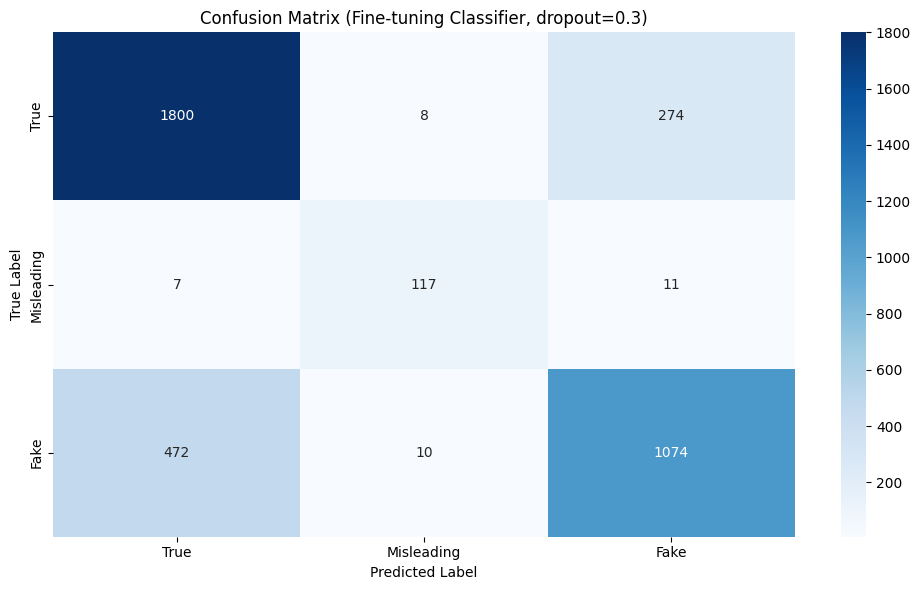

In [84]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Fine-tuning Classifier, dropout=0.3)')
plt.tight_layout()
plt.show()

In [85]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

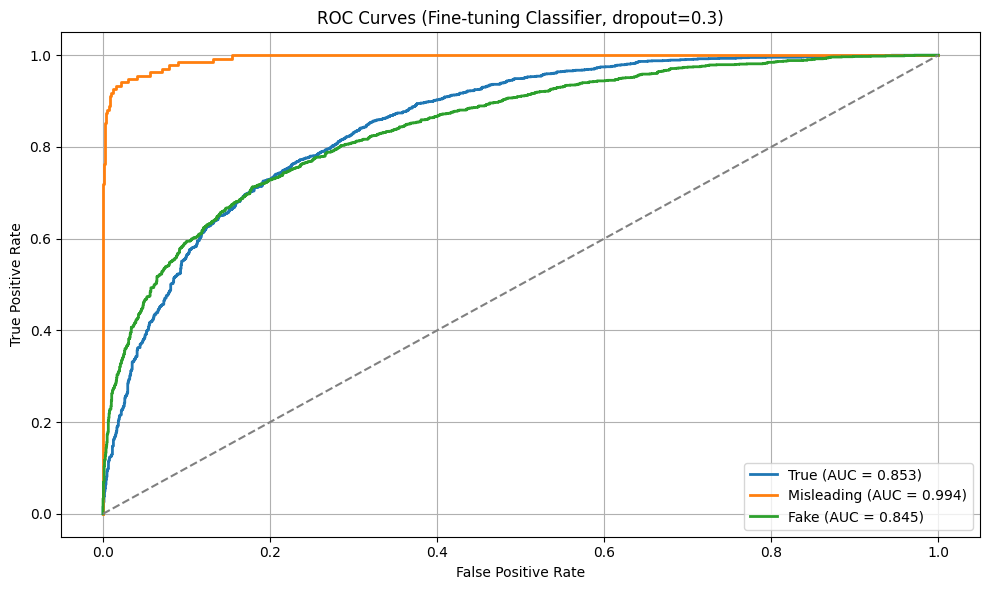

In [86]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Fine-tuning Classifier, dropout=0.3)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

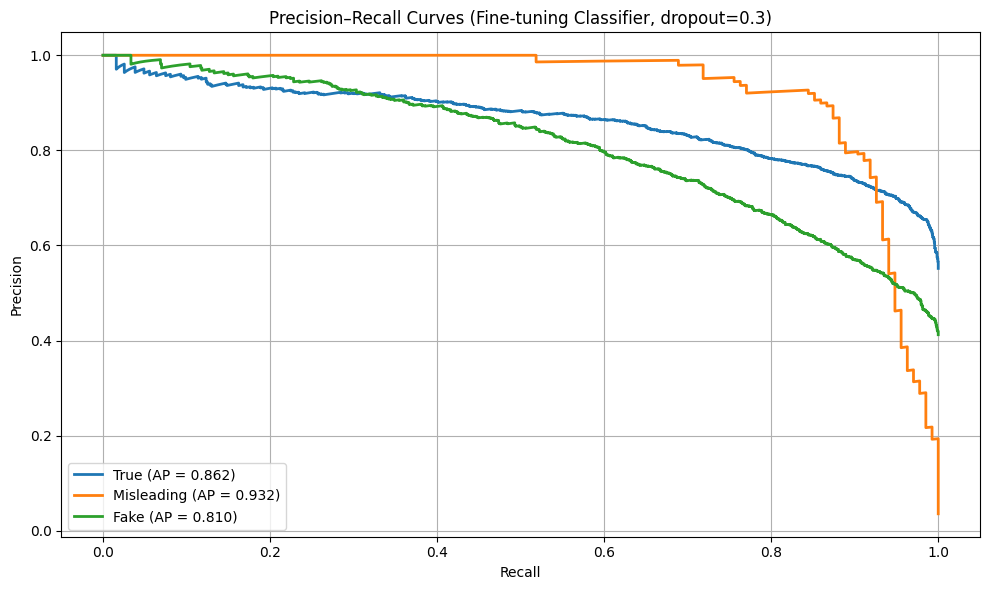

In [87]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Fine-tuning Classifier, dropout=0.3)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Total misclassified samples: 782 / 3773


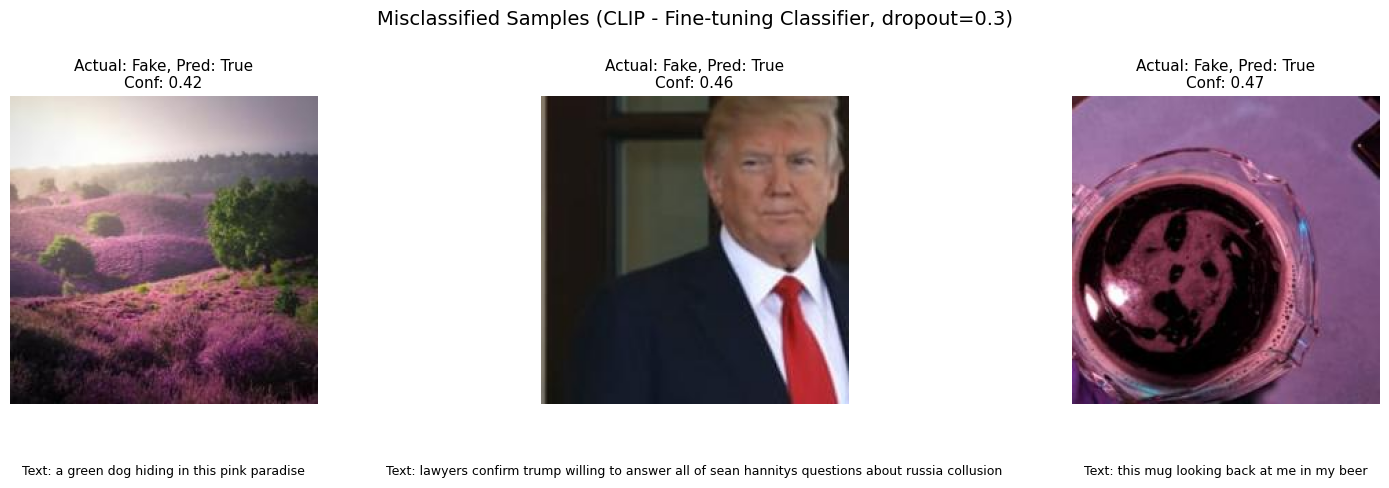

In [89]:
# collect misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]
print(f"Total misclassified samples: {len(misclassified_indices)} / {len(all_labels)}")

# randomly sample a few error cases
num_samples = min(3, len(misclassified_indices))
sampled_errors = random.sample(misclassified_indices, num_samples)

# plot misclassified samples
plt.figure(figsize=(15, 8))

for idx, sample_idx in enumerate(sampled_errors, 1):
    row = test_df.iloc[sample_idx]
    image_id = row["id"]
    image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")

    if not os.path.exists(image_path):
        continue  
    
    image = Image.open(image_path).convert("RGB")

    true_label = label_names[all_labels[sample_idx]]
    pred_label = label_names[all_preds[sample_idx]]
    probs = all_probs[sample_idx]
    confidence = np.max(probs)

    text = str(row.get("clean_title", ""))
    if len(text) > 120:
        text = text[:117] + "..."

    plt.subplot(2, 3, idx)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Actual: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}",
        fontsize=11,
        color="black"
    )
    plt.text(
        0.5, -0.2, 
        f"Text: {text}",
        fontsize=9,
        ha="center",
        va="top",
        wrap=True,
        transform=plt.gca().transAxes
    )

plt.suptitle("Misclassified Samples (CLIP - Fine-tuning Classifier, dropout=0.3)", fontsize=14, y=1)
plt.tight_layout()
plt.show()

### Full Fine-Tuning (dropout=0.2)

In [ ]:
# training setup
EPOCHS = 5
LEARNING_RATE = 1e-5
DROPOUT = 0.2

model = CLIPClassifier(MODEL_NAME, NUM_LABELS, DROPOUT).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.05 * total_steps), 
    num_training_steps=total_steps
)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 151280388


#### Training Loop

In [29]:
best_f1_full_2 = 0.0
train_losses_full_2 = []
train_accuracies_full_2 = []
train_f1s_full_2 = []
val_losses_full_2 = []  
val_accuracies_full_2 = []
val_f1s_full_2 = []

# training loop
for epoch in range(EPOCHS):

    # train on train set
    model.train()
    total_loss = 0.0
    all_train_preds, all_train_labels = [], []
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optimizer.zero_grad()
        logits = model(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask'], 
            pixel_values=batch['pixel_values']
        )
        loss = criterion(logits, batch['labels'])
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        
        preds = torch.argmax(logits, dim=-1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(batch["labels"].cpu().numpy())

        loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average="macro")
    
    train_losses_full_2.append(avg_loss)
    train_accuracies_full_2.append(train_acc)
    train_f1s_full_2.append(train_f1)

    print(f"Train: Loss={avg_loss:.4f}, Accuracy={train_acc:.4f}, F1={train_f1:.4f}")

    # evaluate on validation set
    val_metrics = evaluate_model(model, val_loader)

    val_losses_full_2.append(val_metrics['loss'])
    val_accuracies_full_2.append(val_metrics['accuracy'])
    val_f1s_full_2.append(val_metrics['f1'])
    print(f"Validation: Loss={val_metrics['loss']:.4f}, Accuracy={val_metrics['accuracy']:.4f}, F1={val_metrics['f1']:.4f}")
   
    # save best model
    if val_metrics['f1'] > best_f1_full_2:
        best_f1_full_2 = val_metrics['f1']
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model_full_2.pt'))
        print("Best model saved.")

print(f"Best Validation F1: {best_f1_full_2:.4f}")

Epoch 1/5: 100%|██████████| 1887/1887 [4:26:22<00:00,  8.47s/it, loss=0.851]  


Train: Loss=0.7610, Accuracy=0.7697, F1=0.7464


Evaluating: 100%|██████████| 236/236 [10:39<00:00,  2.71s/it, loss=0.586]


Validation: Loss=0.6226, Accuracy=0.8030, F1=0.7771
Best model saved.


Epoch 2/5: 100%|██████████| 1887/1887 [4:25:14<00:00,  8.43s/it, loss=0.397]  


Train: Loss=0.5154, Accuracy=0.8715, F1=0.8669


Evaluating: 100%|██████████| 236/236 [11:11<00:00,  2.85s/it, loss=0.546]


Validation: Loss=0.5009, Accuracy=0.8380, F1=0.8266
Best model saved.


Epoch 3/5: 100%|██████████| 1887/1887 [4:34:14<00:00,  8.72s/it, loss=0.427]  


Train: Loss=0.3653, Accuracy=0.9248, F1=0.9219


Evaluating: 100%|██████████| 236/236 [10:47<00:00,  2.75s/it, loss=0.527]


Validation: Loss=0.4571, Accuracy=0.8311, F1=0.8270
Best model saved.


Epoch 4/5: 100%|██████████| 1887/1887 [4:23:08<00:00,  8.37s/it, loss=0.156]  


Train: Loss=0.2565, Accuracy=0.9593, F1=0.9606


Evaluating: 100%|██████████| 236/236 [10:31<00:00,  2.67s/it, loss=0.585]


Validation: Loss=0.4610, Accuracy=0.8327, F1=0.8354
Best model saved.


Epoch 5/5: 100%|██████████| 1887/1887 [4:20:11<00:00,  8.27s/it, loss=0.155]  


Train: Loss=0.1961, Accuracy=0.9754, F1=0.9766


Evaluating: 100%|██████████| 236/236 [11:08<00:00,  2.83s/it, loss=0.609]


Validation: Loss=0.4513, Accuracy=0.8420, F1=0.8443
Best model saved.
Best Validation F1: 0.8443


In [32]:
print("=== Full Fine-tuning (dropout=0.2) Metrics ===")
print(f"Train Losses: {train_losses_full_2}")
print(f"Train Accuracies: {train_accuracies_full_2}")
print(f"Train F1 Scores: {train_f1s_full_2}")
print(f"Validation Losses: {val_losses_full_2}")
print(f"Validation Accuracies: {val_accuracies_full_2}")
print(f"Validation F1 Scores: {val_f1s_full_2}")

=== Full Fine-tuning (dropout=0.2) Metrics ===
Train Losses: [0.760953129775068, 0.5153591929918632, 0.36527041419669315, 0.2564541870125021, 0.19607316902786825]
Train Accuracies: [0.7697405480632228, 0.8714669140793266, 0.9248152688955896, 0.9593094535935585, 0.9753802312866563]
Train F1 Scores: [0.746416202100359, 0.8669352017952737, 0.9218677139571657, 0.9605725502295814, 0.9765787624009632]
Validation Losses: [0.6226318550564475, 0.5008696648529021, 0.4570863765932746, 0.46103711647249884, 0.45133583689645185]
Validation Accuracies: [0.8030222693531283, 0.838016967126193, 0.8311240721102863, 0.8327147401908802, 0.8419936373276776]
Validation F1 Scores: [0.777071613192394, 0.8265909302919963, 0.827011138833799, 0.835391822941726, 0.8443154269172594]


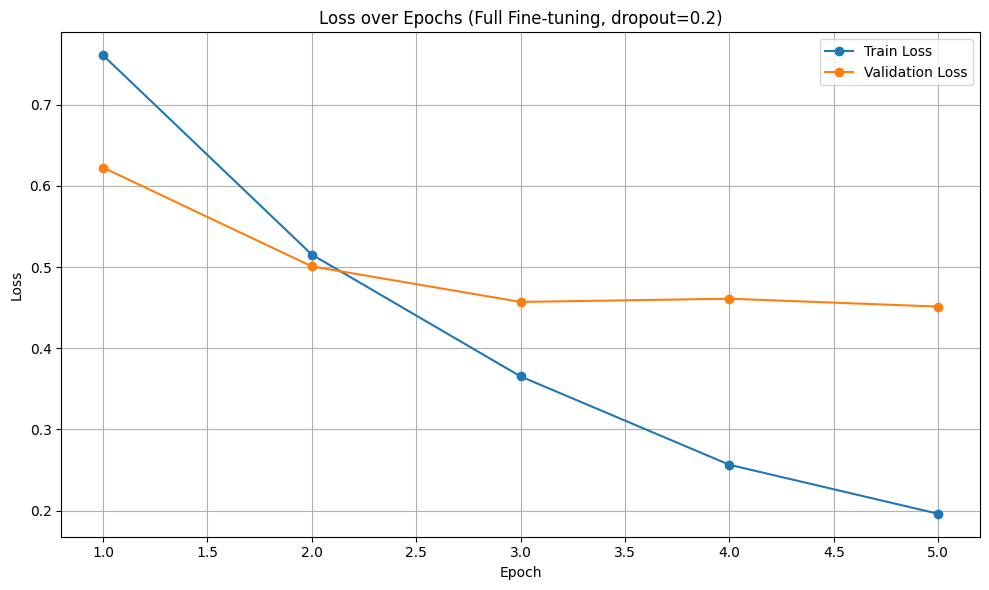

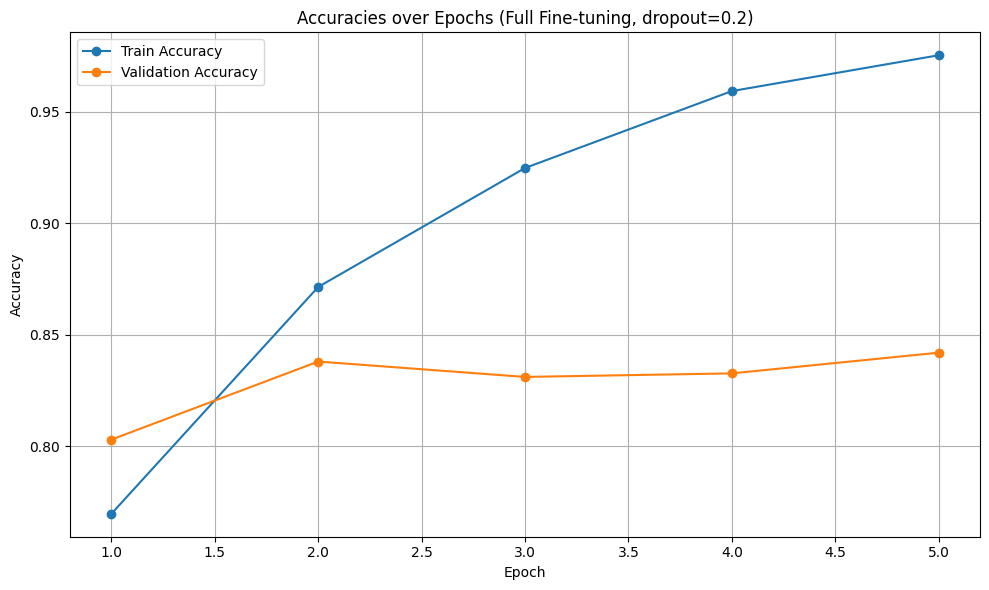

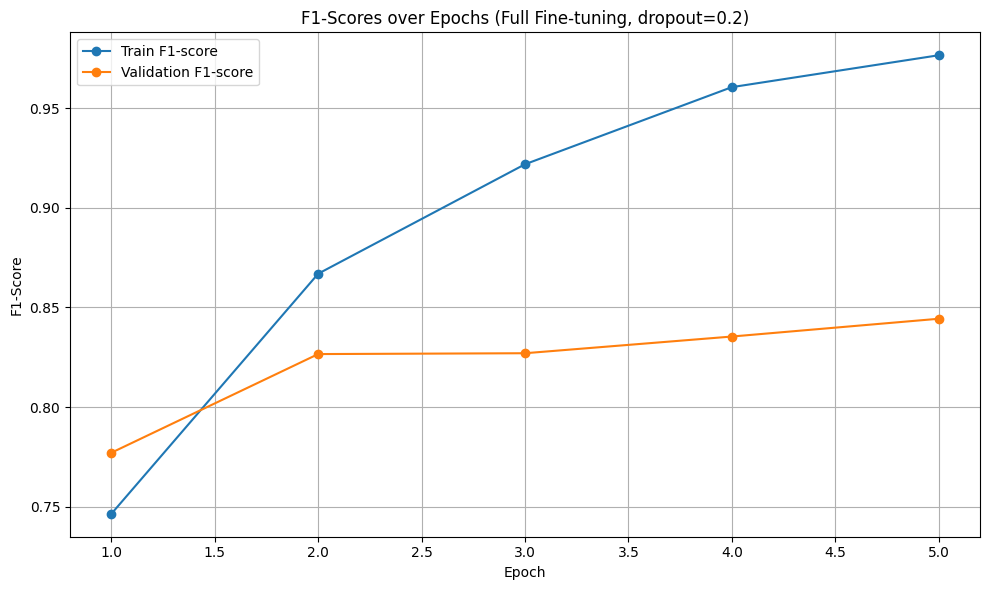

In [33]:
# plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_losses_full_2, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses_full_2, marker='o', label='Validation Loss')
plt.title('Loss over Epochs (Full Fine-tuning, dropout=0.2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_accuracies_full_2, marker='o', label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies_full_2, marker='o', label='Validation Accuracy')
plt.title('Accuracies over Epochs (Full Fine-tuning, dropout=0.2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot f1-score curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_f1s_full_2, marker='o', label='Train F1-score')
plt.plot(range(1, EPOCHS+1), val_f1s_full_2, marker='o', label='Validation F1-score')
plt.title('F1-Scores over Epochs (Full Fine-tuning, dropout=0.2)')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluation on Test Set

In [46]:
# compute evaluation metrics
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_full_2.pt'), map_location=DEVICE))
test_metrics = evaluate_model(model, test_loader)
print("Test Metrics (Full Fine-tuning):", test_metrics)

Evaluating: 100%|██████████| 236/236 [11:26<00:00,  2.91s/it, loss=0.26] 

Test Metrics (Full Fine-tuning): {'loss': 0.4561019572034731, 'accuracy': 0.8436257619931089, 'f1': 0.8540342412920324, 'precision': 0.8670377331112102, 'recall': 0.8423827719320486}


In [47]:
# load best model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_full_2.pt'), map_location=DEVICE))
model.eval()

# define label names
label_names = ['True', 'Misleading', 'Fake']

# collect predictions, labels, and probabilities
all_preds, all_labels, all_probs = [], [], []

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# convert to numpy array
all_probs = np.array(all_probs)

Testing: 100%|██████████| 236/236 [11:18<00:00,  2.88s/it]


In [48]:
# print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (Full Fine-tuning, dropout=0.2) ===\n')
print(report)


=== Classification Report (Full Fine-tuning, dropout=0.2) ===

              precision    recall  f1-score   support

        True     0.8656    0.8569    0.8612      2082
  Misleading     0.9268    0.8444    0.8837       135
        Fake     0.8087    0.8258    0.8172      1556

    accuracy                         0.8436      3773
   macro avg     0.8670    0.8424    0.8540      3773
weighted avg     0.8443    0.8436    0.8439      3773



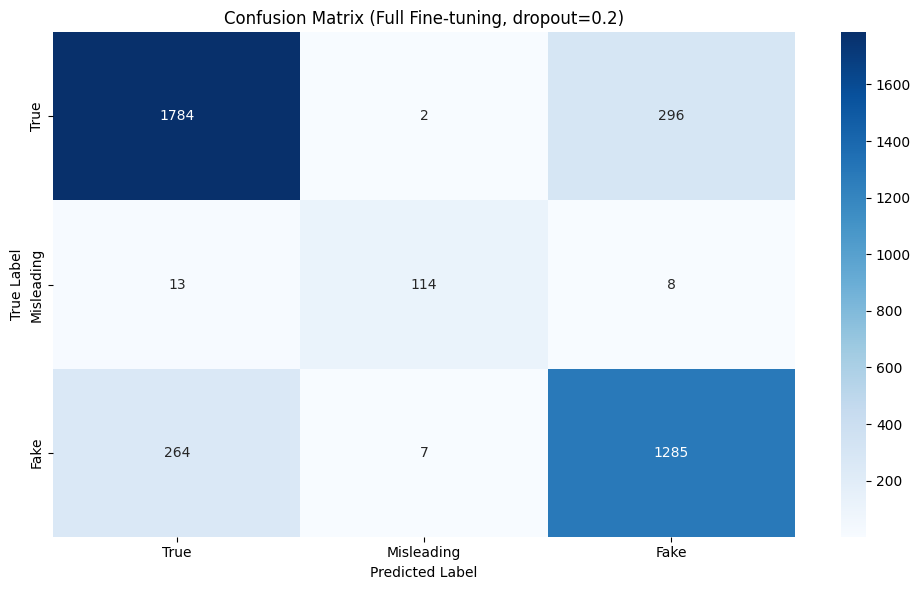

In [49]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Full Fine-tuning, dropout=0.2)')
plt.tight_layout()
plt.show()

In [50]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

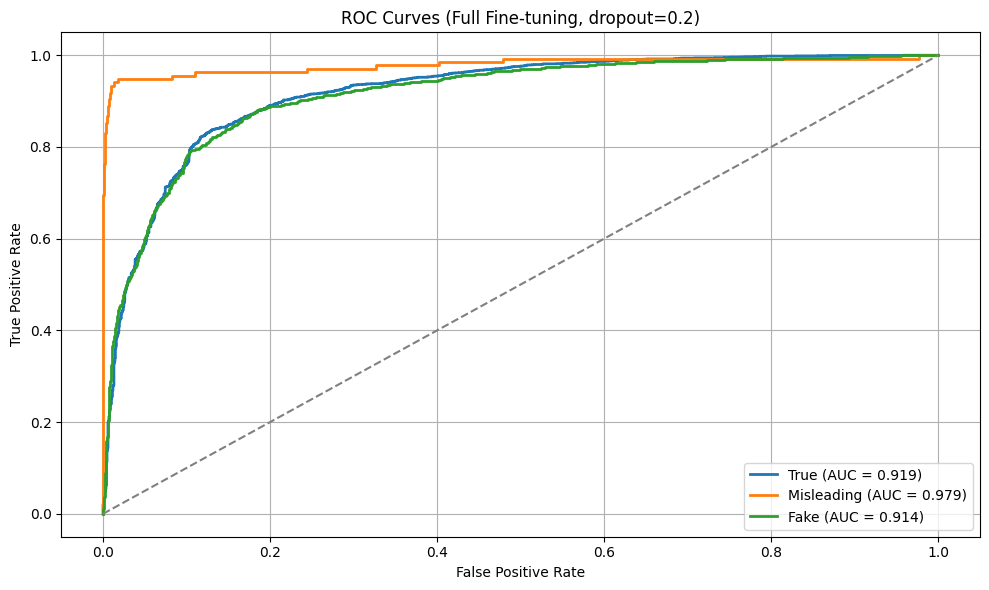

In [51]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Full Fine-tuning, dropout=0.2)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

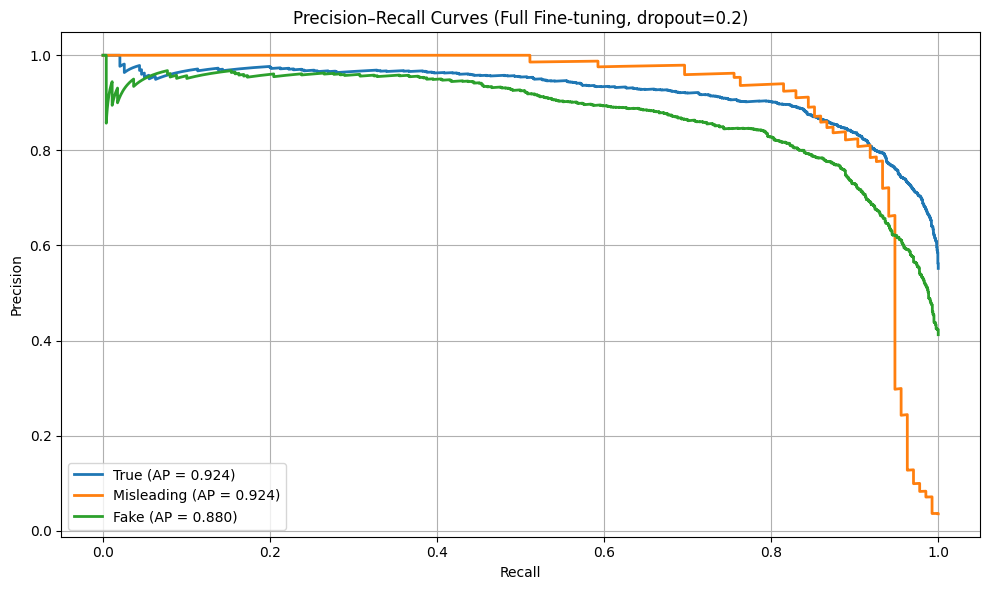

In [53]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Full Fine-tuning, dropout=0.2)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Total misclassified samples: 590 / 3773


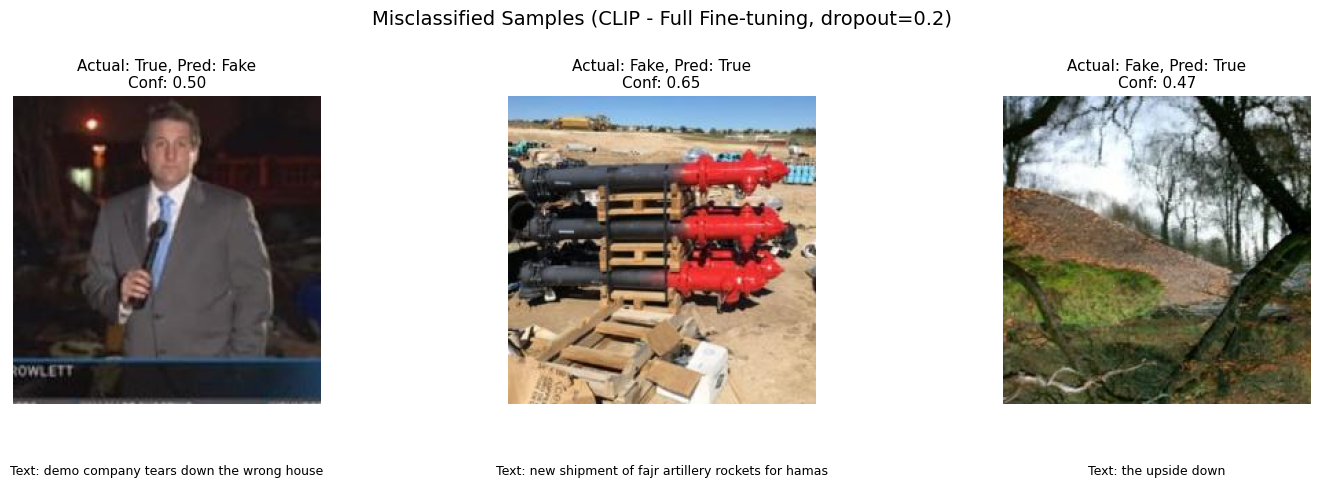

In [72]:
# collect misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]
print(f"Total misclassified samples: {len(misclassified_indices)} / {len(all_labels)}")

# randomly sample a few error cases
num_samples = min(3, len(misclassified_indices))
sampled_errors = random.sample(misclassified_indices, num_samples)

# plot misclassified samples
plt.figure(figsize=(15, 8))

for idx, sample_idx in enumerate(sampled_errors, 1):
    row = test_df.iloc[sample_idx]
    image_id = row["id"]
    image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")

    if not os.path.exists(image_path):
        continue  
    
    image = Image.open(image_path).convert("RGB")

    true_label = label_names[all_labels[sample_idx]]
    pred_label = label_names[all_preds[sample_idx]]
    probs = all_probs[sample_idx]
    confidence = np.max(probs)

    text = str(row.get("clean_title", ""))
    if len(text) > 120:
        text = text[:117] + "..."

    plt.subplot(2, 3, idx)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Actual: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}",
        fontsize=11,
        color="black"
    )
    plt.text(
        0.5, -0.2, 
        f"Text: {text}",
        fontsize=9,
        ha="center",
        va="top",
        wrap=True,
        transform=plt.gca().transAxes
    )

plt.suptitle("Misclassified Samples (CLIP - Full Fine-tuning, dropout=0.2)", fontsize=14, y=1)
plt.tight_layout()
plt.show()

### Full Fine-Tuning (dropout=0.3)

In [90]:
# training setup
EPOCHS = 5
LEARNING_RATE = 1e-5
DROPOUT = 0.3

model = CLIPClassifier(MODEL_NAME, NUM_LABELS, DROPOUT).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.05 * total_steps), 
    num_training_steps=total_steps
)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 151280388


#### Training Loop

In [91]:
best_f1_full_3 = 0.0
train_losses_full_3 = []
train_accuracies_full_3 = []
train_f1s_full_3 = []
val_losses_full_3 = []  
val_accuracies_full_3 = []
val_f1s_full_3 = []

# training loop
for epoch in range(EPOCHS):

    # train on train set
    model.train()
    total_loss = 0.0
    all_train_preds, all_train_labels = [], []
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optimizer.zero_grad()
        logits = model(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask'], 
            pixel_values=batch['pixel_values']
        )
        loss = criterion(logits, batch['labels'])
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        
        preds = torch.argmax(logits, dim=-1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(batch["labels"].cpu().numpy())

        loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average="macro")
    
    train_losses_full_3.append(avg_loss)
    train_accuracies_full_3.append(train_acc)
    train_f1s_full_3.append(train_f1)

    print(f"Train: Loss={avg_loss:.4f}, Accuracy={train_acc:.4f}, F1={train_f1:.4f}")

    # evaluate on validation set
    val_metrics = evaluate_model(model, val_loader)

    val_losses_full_3.append(val_metrics['loss'])
    val_accuracies_full_3.append(val_metrics['accuracy'])
    val_f1s_full_3.append(val_metrics['f1'])
    print(f"Validation: Loss={val_metrics['loss']:.4f}, Accuracy={val_metrics['accuracy']:.4f}, F1={val_metrics['f1']:.4f}")
   
    # save best model
    if val_metrics['f1'] > best_f1_full_3:
        best_f1_full_3 = val_metrics['f1']
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model_full_3.pt'))
        print("Best model saved.")

print(f"Best Validation F1: {best_f1_full_3:.4f}")

Epoch 1/5: 100%|██████████| 1887/1887 [4:32:20<00:00,  8.66s/it, loss=0.833]  


Train: Loss=0.7688, Accuracy=0.7436, F1=0.6821


Evaluating: 100%|██████████| 236/236 [16:06<00:00,  4.10s/it, loss=0.636]


Validation: Loss=0.6381, Accuracy=0.8073, F1=0.7944
Best model saved.


Epoch 2/5: 100%|██████████| 1887/1887 [4:41:19<00:00,  8.95s/it, loss=0.505]  


Train: Loss=0.5313, Accuracy=0.8626, F1=0.8436


Evaluating: 100%|██████████| 236/236 [10:59<00:00,  2.79s/it, loss=0.692]


Validation: Loss=0.5278, Accuracy=0.8277, F1=0.8107
Best model saved.


Epoch 3/5: 100%|██████████| 1887/1887 [4:29:50<00:00,  8.58s/it, loss=0.471]  


Train: Loss=0.3793, Accuracy=0.9181, F1=0.9082


Evaluating: 100%|██████████| 236/236 [10:50<00:00,  2.76s/it, loss=0.612]


Validation: Loss=0.4915, Accuracy=0.8380, F1=0.8341
Best model saved.


Epoch 4/5: 100%|██████████| 1887/1887 [4:26:43<00:00,  8.48s/it, loss=0.166]  


Train: Loss=0.2733, Accuracy=0.9560, F1=0.9522


Evaluating: 100%|██████████| 236/236 [10:46<00:00,  2.74s/it, loss=0.749]


Validation: Loss=0.4620, Accuracy=0.8324, F1=0.8314


Epoch 5/5: 100%|██████████| 1887/1887 [4:28:26<00:00,  8.54s/it, loss=0.538]  


Train: Loss=0.2088, Accuracy=0.9734, F1=0.9705


Evaluating: 100%|██████████| 236/236 [11:03<00:00,  2.81s/it, loss=0.658]


Validation: Loss=0.4600, Accuracy=0.8367, F1=0.8443
Best model saved.
Best Validation F1: 0.8443


In [92]:
print("=== Full Fine-tuning (dropout=0.3) Metrics ===")
print(f"Train Losses: {train_losses_full_3}")
print(f"Train Accuracies: {train_accuracies_full_3}")
print(f"Train F1 Scores: {train_f1s_full_3}")
print(f"Validation Losses: {val_losses_full_3}")
print(f"Validation Accuracies: {val_accuracies_full_3}")
print(f"Validation F1 Scores: {val_f1s_full_3}")

=== Full Fine-tuning (dropout=0.3) Metrics ===
Train Losses: [0.7687550861335142, 0.5313302450825692, 0.37925548538778847, 0.2732617641386053, 0.2087772865584747]
Train Accuracies: [0.7435634050167335, 0.8626197024420955, 0.9180887372013652, 0.955962755558501, 0.973425229464197]
Train F1 Scores: [0.6821106935445927, 0.8435611811442371, 0.9081613733324959, 0.952218229624481, 0.9705053767871584]
Validation Losses: [0.638088537348529, 0.5278391848176213, 0.49149303895942237, 0.46198396252120955, 0.4600165736372188]
Validation Accuracies: [0.8072640509013785, 0.827677624602333, 0.838016967126193, 0.8324496288441146, 0.8366914103923648]
Validation F1 Scores: [0.794396251484093, 0.8107153387512339, 0.8341095698340618, 0.8313685501912019, 0.8443304637596057]


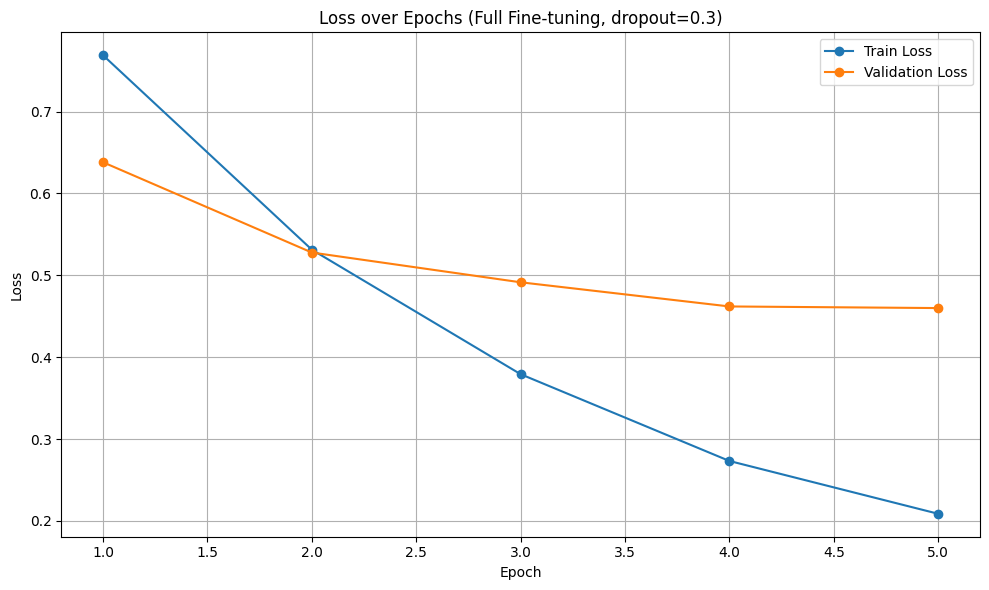

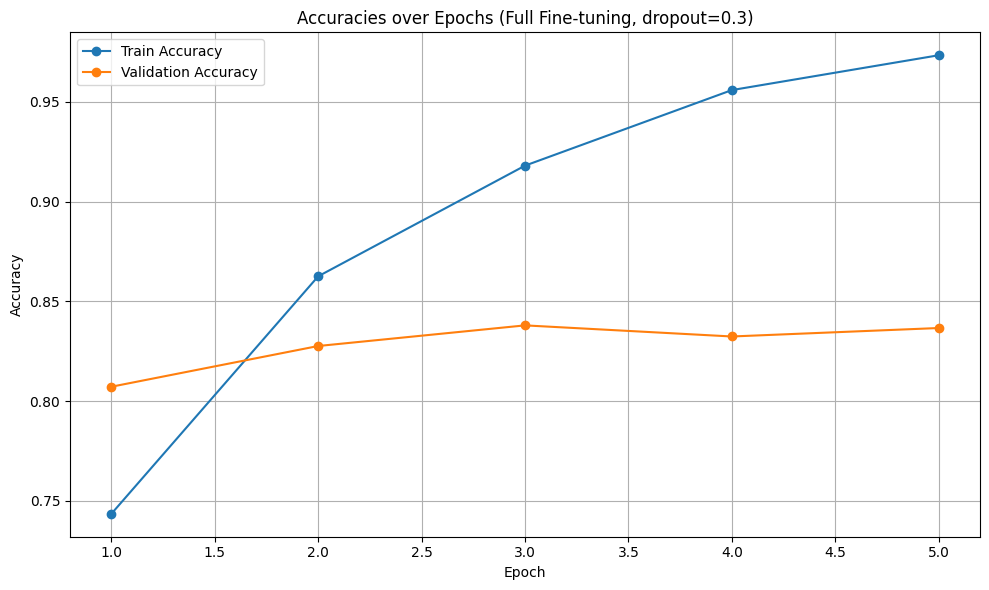

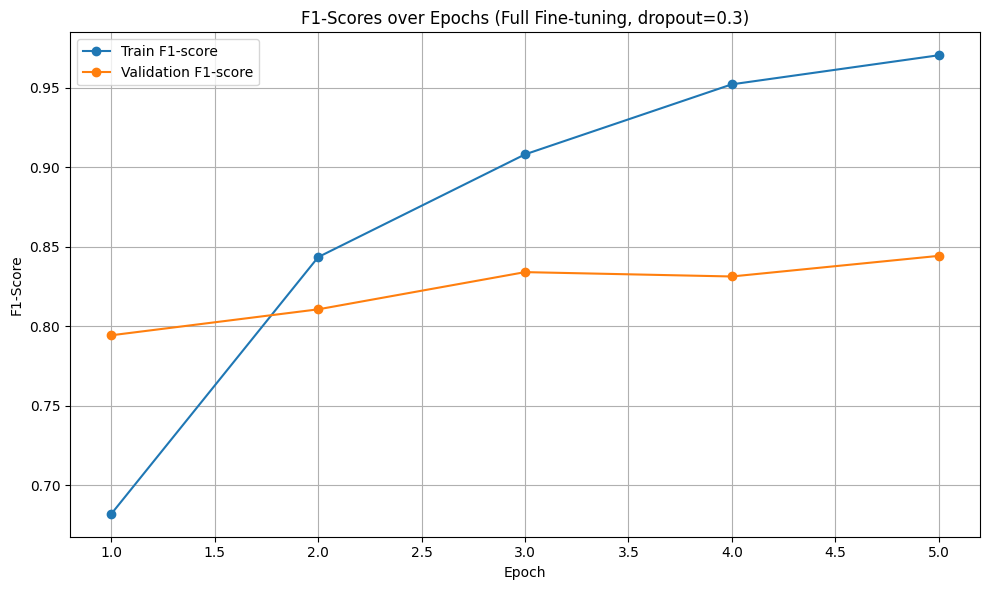

In [93]:
# plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_losses_full_3, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses_full_3, marker='o', label='Validation Loss')
plt.title('Loss over Epochs (Full Fine-tuning, dropout=0.3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_accuracies_full_3, marker='o', label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies_full_3, marker='o', label='Validation Accuracy')
plt.title('Accuracies over Epochs (Full Fine-tuning, dropout=0.3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot f1-score curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_f1s_full_3, marker='o', label='Train F1-score')
plt.plot(range(1, EPOCHS+1), val_f1s_full_3, marker='o', label='Validation F1-score')
plt.title('F1-Scores over Epochs (Full Fine-tuning, dropout=0.3)')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluation on Test Set

In [94]:
# compute evaluation metrics
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_full_3.pt'), map_location=DEVICE))
test_metrics = evaluate_model(model, test_loader)
print("Test Metrics (Full Fine-tuning):", test_metrics)

Evaluating: 100%|██████████| 236/236 [11:03<00:00,  2.81s/it, loss=0.258]

Test Metrics (Full Fine-tuning): {'loss': 0.47190670946897084, 'accuracy': 0.841505433342168, 'f1': 0.8440813179440368, 'precision': 0.8558891709725162, 'recall': 0.8333088995294607}


In [95]:
# load best model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_full_3.pt'), map_location=DEVICE))
model.eval()

# define label names
label_names = ['True', 'Misleading', 'Fake']

# collect predictions, labels, and probabilities
all_preds, all_labels, all_probs = [], [], []

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# convert to numpy array
all_probs = np.array(all_probs)

Testing: 100%|██████████| 236/236 [11:06<00:00,  2.82s/it]


In [96]:
# print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (Full Fine-tuning, dropout=0.3) ===\n')
print(report)


=== Classification Report (Full Fine-tuning, dropout=0.3) ===

              precision    recall  f1-score   support

        True     0.8601    0.8622    0.8611      2082
  Misleading     0.8952    0.8222    0.8571       135
        Fake     0.8124    0.8156    0.8140      1556

    accuracy                         0.8415      3773
   macro avg     0.8559    0.8333    0.8441      3773
weighted avg     0.8417    0.8415    0.8415      3773



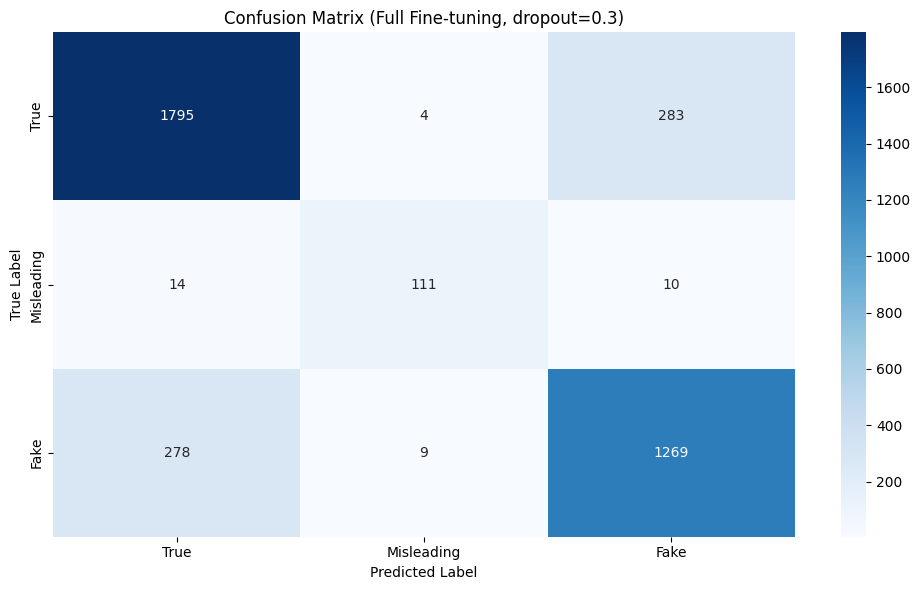

In [97]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Full Fine-tuning, dropout=0.3)')
plt.tight_layout()
plt.show()

In [98]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

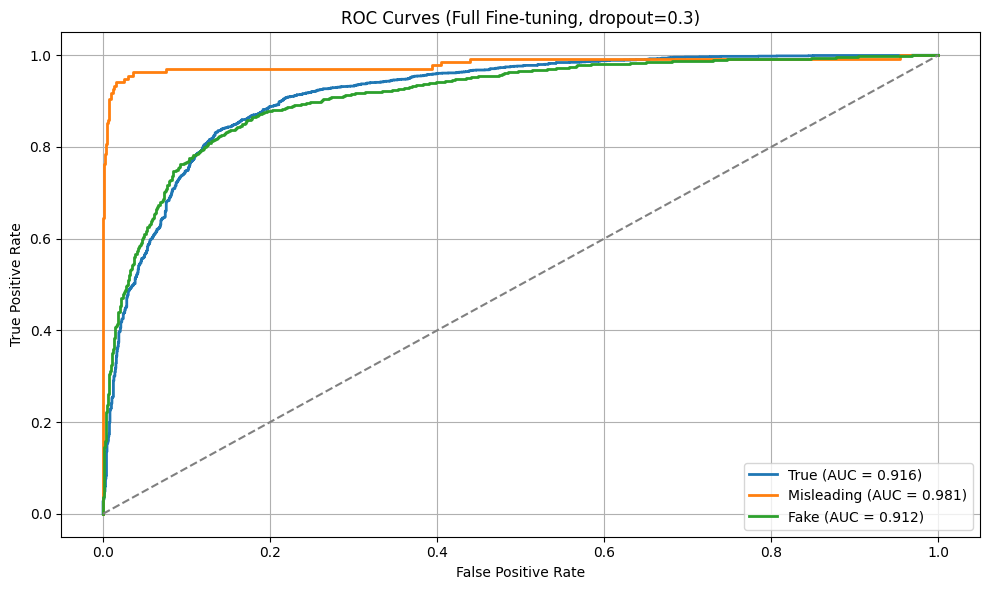

In [99]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Full Fine-tuning, dropout=0.3)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

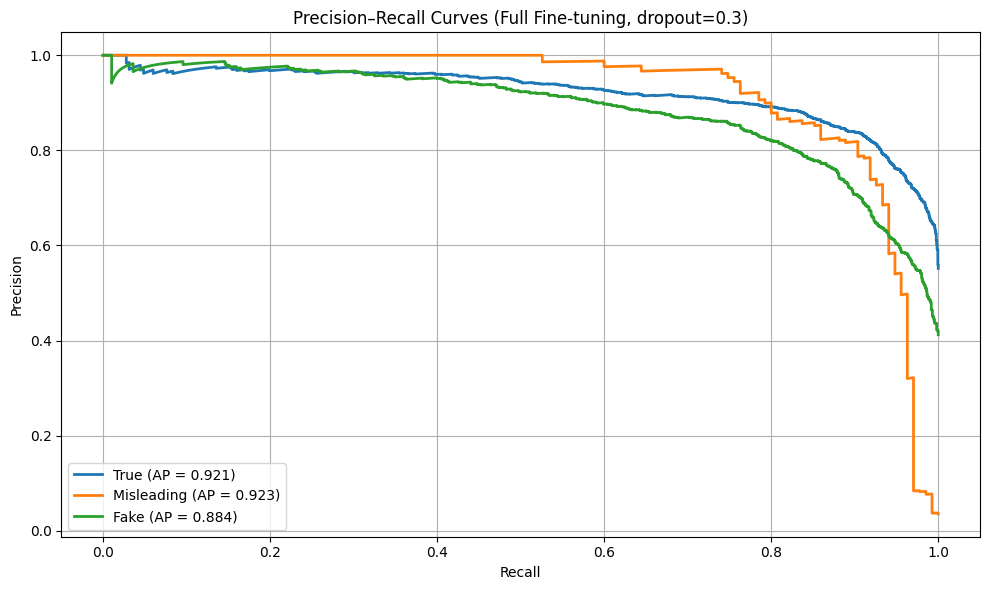

In [100]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Full Fine-tuning, dropout=0.3)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Total misclassified samples: 598 / 3773


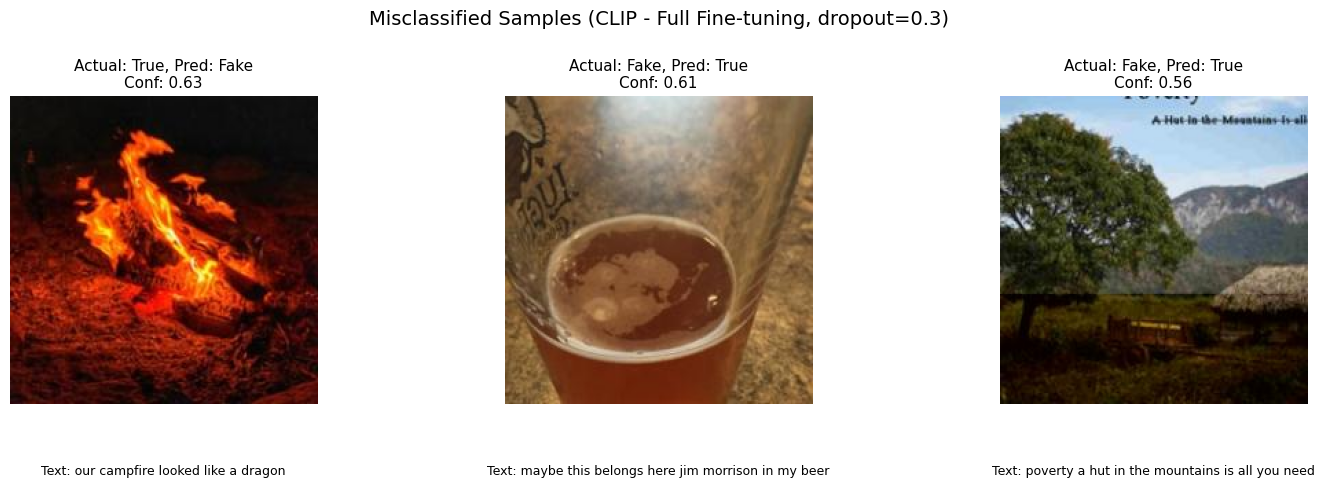

In [116]:
# collect misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]
print(f"Total misclassified samples: {len(misclassified_indices)} / {len(all_labels)}")

# randomly sample a few error cases
num_samples = min(3, len(misclassified_indices))
sampled_errors = random.sample(misclassified_indices, num_samples)

# plot misclassified samples
plt.figure(figsize=(15, 8))

for idx, sample_idx in enumerate(sampled_errors, 1):
    row = test_df.iloc[sample_idx]
    image_id = row["id"]
    image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")

    if not os.path.exists(image_path):
        continue  
    
    image = Image.open(image_path).convert("RGB")

    true_label = label_names[all_labels[sample_idx]]
    pred_label = label_names[all_preds[sample_idx]]
    probs = all_probs[sample_idx]
    confidence = np.max(probs)

    text = str(row.get("clean_title", ""))
    if len(text) > 120:
        text = text[:117] + "..."

    plt.subplot(2, 3, idx)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Actual: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}",
        fontsize=11,
        color="black"
    )
    plt.text(
        0.5, -0.2, 
        f"Text: {text}",
        fontsize=9,
        ha="center",
        va="top",
        wrap=True,
        transform=plt.gca().transAxes
    )

plt.suptitle("Misclassified Samples (CLIP - Full Fine-tuning, dropout=0.3)", fontsize=14, y=1)
plt.tight_layout()
plt.show()